# <center> Ensemble Learning Project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
import time
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

## Datasets infos

In [9]:
import numpy as np
import pandas as pd

# Liste des noms de fichiers
dataset_files = ['data/kaggle_source_cate_{}_test.npy'.format(i) for i in range(4)]

# Initialisez des listes pour stocker les données
datasets = []
X_test_shapes = []
X_train_shapes = []
y_test_shapes = []
y_train_shapes = []
train_dist_labels = []

# Boucle à travers les fichiers
for i, file_path in enumerate(dataset_files):
    # Charger les données à partir du fichier
    X_test = np.load(file_path)
    y_test = np.load(file_path.replace('test.npy', 'test_label.npy'))
    X_train = np.load(file_path.replace('test.npy', 'train.npy'))
    y_train = np.load(file_path.replace('test.npy', 'train_label.npy'))
    
    # Ajoutez les données aux listes
    datasets.append('kaggle_source_cate_{}'.format(i))
    X_test_shapes.append(X_test.shape)
    X_train_shapes.append(X_train.shape)
    y_test_shapes.append(y_test.shape)
    y_train_shapes.append(y_train.shape)
    distribution = (np.sum(y_train[:, 1]) / y_train.shape[0]) * 100  # Supposant que la colonne 1 de y soit la classe
    train_dist_labels.append(distribution)

# Créer un DataFrame
data = {
    'dataset': datasets,
    'shape': [(np.sum(X_train_shape[0] + X_test_shape[0]), X_train_shape[1] + 1) for X_train_shape, X_test_shape in zip(X_train_shapes, X_test_shapes)],  # +1 pour la colonne y
    'X_test_shape': X_test_shapes,
    'X_train_shape': X_train_shapes,
    'y_test_shape': y_test_shapes,
    'y_train_shape': y_train_shapes,
    'Train_dist_label': train_dist_labels
}

df = pd.DataFrame(data)

# Affichez le DataFrame
df

,dataset,shape,X_test_shape,X_train_shape,y_test_shape,y_train_shape,Train_dist_label
0,kaggle_source_cate_0,"(54744, 52)","(13686, 51)","(41058, 51)","(13686, 2)","(41058, 2)",10.041892
1,kaggle_source_cate_1,"(54744, 52)","(13686, 51)","(41058, 51)","(13686, 2)","(41058, 2)",9.956647
2,kaggle_source_cate_2,"(54744, 52)","(13686, 51)","(41058, 51)","(13686, 2)","(41058, 2)",9.832432
3,kaggle_source_cate_3,"(54744, 52)","(13686, 51)","(41058, 51)","(13686, 2)","(41058, 2)",9.815383


## Load data

Nous créeons une fonction pour charger les données et preprocess les y pour ne garder que la 2e colonne (classe) :

In [2]:
def load_and_preprocess_data(dataset_number):
    """
    Charge les données et effectue le prétraitement pour un dataset donné.

    Args:
    dataset_number (int): Numéro du dataset (de 0 à 3).

    Returns:
    np.ndarray: X_train, X_test, y_train, y_test prétraités.
    """

    # Charger les données
    X_test = np.load(f'data/kaggle_source_cate_{dataset_number}_test.npy')
    y_test = np.load(f'data/kaggle_source_cate_{dataset_number}_test_label.npy')
    X_train = np.load(f'data/kaggle_source_cate_{dataset_number}_train.npy')
    y_train = np.load(f'data/kaggle_source_cate_{dataset_number}_train_label.npy')

    # Garder uniquement la deuxième colonne de y
    y_train = y_train[:, 1]
    y_test = y_test[:, 1]

    return X_train, X_test, y_train, y_test

In [3]:
# Dataset 1
X_train_0, X_test_0, y_train_0, y_test_0 = load_and_preprocess_data(0)

# Dataset 2
X_train_1, X_test_1, y_train_1, y_test_1 = load_and_preprocess_data(1)

# Dataset 3
X_train_2, X_test_2, y_train_2, y_test_2 = load_and_preprocess_data(2)

# Dataset 4
X_train_3, X_test_3, y_train_3, y_test_3 = load_and_preprocess_data(3)

## X_train data visualization

Nous explorons rapidement la distribution des données pour de potentiels pré-traitement.
Les datasets n'ont aucunes valeurs manquantes.

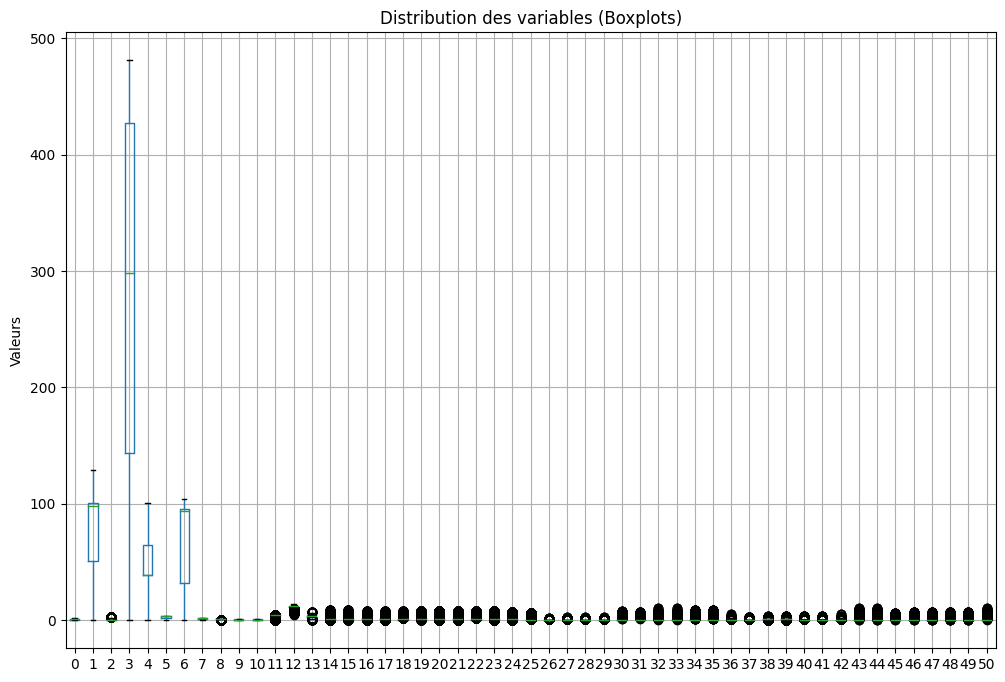

In [12]:
import matplotlib.pyplot as plt

# Modifier le X_train pour observer la distribution des autres set d'entrainement

test = pd.DataFrame(X_train_0)

# Sélectionnez les dix premières variables (colonnes 0 à 9)
subset_data = test.iloc[:, 0:51]

# Créez des boxplots pour chaque colonne
plt.figure(figsize=(12, 8))
subset_data.boxplot()
plt.title('Distribution des variables (Boxplots)')
plt.ylabel('Valeurs')
plt.show()

**Il semble qu'une normalisation soit nécessaire avant l'entrainement de nos modèles.**

## Model training

### Data

In [4]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
import time
import numpy as np
import pandas as pd

# Définissez les ensembles de données
datasets = ['X_train_0', 'X_train_1', 'X_train_2', 'X_train_3']
test_datasets = ['X_test_0', 'X_test_1', 'X_test_2', 'X_test_3']
labels = ['y_train_0', 'y_train_1', 'y_train_2', 'y_train_3']
test_labels = ['y_test_0', 'y_test_1', 'y_test_2', 'y_test_3']

# Créez un objet StratifiedKFold pour la validation croisée en spécifiant un random state pour avoir les mêmes folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


### Penalized Logistic Regression

In [35]:
# Définir les modèles et les paramètres à rechercher
models = {
    'Régression Logistique': (LogisticRegression(solver='liblinear'), {
        'penalty': ['l2', 'l1'],
        'C': [0.1, 1, 10]
    })
}

# Initialiser une liste pour stocker les résultats
results = []

# Parcourir chaque dataset et appliquer le modèle de régression logistique
for dataset, label, test_dataset, test_label in zip(datasets, labels, test_datasets, test_labels):
    X_train, y_train = locals()[dataset], locals()[label]
    X_test, y_test = locals()[test_dataset], locals()[test_label]

    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        # Normaliser les données d'entraînement à chaque itération
        norm = Normalizer()
        X_train_fold_normalized = norm.fit_transform(X_train_fold)
        X_test_fold_normalized = norm.transform(X_test_fold)

        for model_name, (model, param_grid) in models.items():
            # Créer un objet GridSearchCV
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=skf)

            # Mesurer le temps d'exécution
            start_time = time.time()

            # Exécuter la recherche sur la grille
            grid_search.fit(X_train_fold_normalized, y_train_fold)

            # Obtenir les résultats de la validation croisée
            cv_results = grid_search.cv_results_
            penalties = cv_results['param_penalty']
            C_values = cv_results['param_C']
            f1_scores = cv_results['mean_test_score']

            # Ajouter les résultats à la liste
            for penalty, C, f1 in zip(penalties, C_values, f1_scores):
                results.append({
                    'Dataset': dataset,
                    'Model': model_name,
                    'Penalty': penalty,
                    'C': C,
                    'F1 Score': f1,
                    'Training Time (s)': time.time() - start_time
                })

# Créer un DataFrame à partir des résultats
results_df = pd.DataFrame(results)

# Afficher le DataFrame
print(results_df)


       Dataset                  Model Penalty     C  F1 Score  \
0    X_train_0  Régression Logistique      l2   0.1  0.000000   
1    X_train_0  Régression Logistique      l1   0.1  0.000000   
2    X_train_0  Régression Logistique      l2   1.0  0.035286   
3    X_train_0  Régression Logistique      l1   1.0  0.351231   
4    X_train_0  Régression Logistique      l2  10.0  0.150354   
..         ...                    ...     ...   ...       ...   
115  X_train_3  Régression Logistique      l1   0.1  0.000000   
116  X_train_3  Régression Logistique      l2   1.0  0.038518   
117  X_train_3  Régression Logistique      l1   1.0  0.364886   
118  X_train_3  Régression Logistique      l2  10.0  0.155329   
119  X_train_3  Régression Logistique      l1  10.0  0.535591   

     Training Time (s)  
0            24.885809  
1            24.885815  
2            24.885818  
3            24.885820  
4            24.885823  
..                 ...  
115          25.955982  
116          25.955

In [36]:
results_df

,Dataset,Model,Penalty,C,F1 Score,Training Time (s)
0,X_train_0,Régression Logistique,l2,0.1,0.000000,24.885809
1,X_train_0,Régression Logistique,l1,0.1,0.000000,24.885815
2,X_train_0,Régression Logistique,l2,1.0,0.035286,24.885818
3,X_train_0,Régression Logistique,l1,1.0,0.351231,24.885820
4,X_train_0,Régression Logistique,l2,10.0,0.150354,24.885823
...,...,...,...,...,...,...
115,X_train_3,Régression Logistique,l1,0.1,0.000000,25.955982
116,X_train_3,Régression Logistique,l2,1.0,0.038518,25.955985
117,X_train_3,Régression Logistique,l1,1.0,0.364886,25.955987
118,X_train_3,Régression Logistique,l2,10.0,0.155329,25.955990


In [38]:
# Trier le DataFrame par F1 Score dans l'ordre décroissant
results_df_sorted = results_df.sort_values(by='F1 Score', ascending=False)

# Supprimer les lignes en double basées sur le nom du dataset, en conservant uniquement la première occurrence (la meilleure)
best_results_df = results_df_sorted.drop_duplicates(subset='Dataset', keep='first')

# Réinitialiser les index du DataFrame résultant
best_results_df.reset_index(drop=True, inplace=True)

# Afficher le DataFrame contenant les meilleurs scores F1 pour chaque dataset
print(best_results_df)

     Dataset                  Model Penalty     C  F1 Score  Training Time (s)
0  X_train_2  Régression Logistique      l1  10.0  0.536881          28.302266
1  X_train_3  Régression Logistique      l1  10.0  0.535591          25.955992
2  X_train_1  Régression Logistique      l1  10.0  0.534838          25.420057
3  X_train_0  Régression Logistique      l1  10.0  0.523064          27.291655


**Les meilleurs paramètres pour nos 4 datasets semblent être une pénalité Lasso de 10**

### Bagging Classifier Logistic Regression

In [40]:
from sklearn.ensemble import BaggingClassifier

# Définir le modèle de régression logistique L1 avec C=10
base_estimator = LogisticRegression(solver='liblinear', penalty='l1', C=10)

# Initialiser une liste pour stocker les résultats
results = []

# Parcourir chaque dataset et appliquer le modèle de Bagging avec le modèle de régression logistique L1 et C=10
for dataset, label, test_dataset, test_label in zip(datasets, labels,
                                                    test_datasets,
                                                    test_labels):
    X_train, y_train = locals()[dataset], locals()[label]
    X_test, y_test = locals()[test_dataset], locals()[test_label]

    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        # Normaliser les données d'entraînement à chaque itération
        norm = Normalizer()
        X_train_fold_normalized = norm.fit_transform(X_train_fold)
        X_test_fold_normalized = norm.transform(X_test_fold)

        # Créer un Bagging Classifier avec le modèle de régression logistique L1 et C=10
        bagging_model = BaggingClassifier(base_estimator=base_estimator,
                                          random_state=42)

        # Mesurer le temps d'exécution
        start_time = time.time()

        # Entraîner le modèle
        bagging_model.fit(X_train_fold_normalized, y_train_fold)

        # Prédire sur les données de test
        y_pred = bagging_model.predict(X_test_fold_normalized)

        # Calculer le score F1 pour les prédictions
        f1 = f1_score(y_test_fold, y_pred)

        # Ajouter les résultats à la liste
        results.append({
            'Dataset': dataset,
            'Model': 'Bagging Classifier (Régression Logistique L1, C=10)',
            'F1 Score': f1,
            'Training Time (s)': time.time() - start_time
        })

# Créer un DataFrame à partir des résultats
results_df = pd.DataFrame(results)

# Afficher le DataFrame
results_df

/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 

,Dataset,Model,F1 Score,Training Time (s)
0,X_train_0,"Bagging Classifier (Régression Logistique L1, ...",0.533871,20.673842
1,X_train_0,"Bagging Classifier (Régression Logistique L1, ...",0.559677,19.962358
2,X_train_0,"Bagging Classifier (Régression Logistique L1, ...",0.508278,19.066781
3,X_train_0,"Bagging Classifier (Régression Logistique L1, ...",0.532468,18.597045
4,X_train_0,"Bagging Classifier (Régression Logistique L1, ...",0.517129,20.187070
5,X_train_1,"Bagging Classifier (Régression Logistique L1, ...",0.528830,19.490861
6,X_train_1,"Bagging Classifier (Régression Logistique L1, ...",0.536626,18.187291
7,X_train_1,"Bagging Classifier (Régression Logistique L1, ...",0.533662,19.564363
8,X_train_1,"Bagging Classifier (Régression Logistique L1, ...",0.535627,20.405990
9,X_train_1,"Bagging Classifier (Régression Logistique L1, ...",0.543831,19.906570


In [41]:
# Trier le DataFrame par F1 Score dans l'ordre décroissant
Bagg_df_sorted = results_df.sort_values(by='F1 Score', ascending=False)

# Supprimer les lignes en double basées sur le nom du dataset, en conservant uniquement la première occurrence (la meilleure)
Bagging_results = Bagg_df_sorted.drop_duplicates(subset='Dataset', keep='first')

# Réinitialiser les index du DataFrame résultant
Bagging_results.reset_index(drop=True, inplace=True)

# Afficher le DataFrame contenant les meilleurs scores F1 pour chaque dataset
Bagging_results

,Dataset,Model,F1 Score,Training Time (s)
0,X_train_2,"Bagging Classifier (Régression Logistique L1, ...",0.574657,18.802217
1,X_train_0,"Bagging Classifier (Régression Logistique L1, ...",0.559677,19.962358
2,X_train_3,"Bagging Classifier (Régression Logistique L1, ...",0.557724,19.176919
3,X_train_1,"Bagging Classifier (Régression Logistique L1, ...",0.543831,19.906570


### Random Forest Classifier

In [42]:
from sklearn.ensemble import RandomForestClassifier

# Définir les modèles et les paramètres à rechercher
models = {
    'Random Forest Classifier': (RandomForestClassifier(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    })
}

# Initialiser une liste pour stocker les résultats
results = []

# Parcourir chaque dataset et appliquer le modèle de Random Forest Classifier
for dataset, label, test_dataset, test_label in zip(datasets, labels, test_datasets, test_labels):
    X_train, y_train = locals()[dataset], locals()[label]
    X_test, y_test = locals()[test_dataset], locals()[test_label]

    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        # Normaliser les données d'entraînement à chaque itération
        norm = Normalizer()
        X_train_fold_normalized = norm.fit_transform(X_train_fold)
        X_test_fold_normalized = norm.transform(X_test_fold)

        for model_name, (model, param_grid) in models.items():
            # Créer un objet GridSearchCV
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=skf)

            # Mesurer le temps d'exécution
            start_time = time.time()

            # Exécuter la recherche sur la grille
            grid_search.fit(X_train_fold_normalized, y_train_fold)

            # Obtenir les résultats de la validation croisée
            cv_results = grid_search.cv_results_
            estimators = cv_results['param_n_estimators']
            max_depths = cv_results['param_max_depth']
            min_samples_splits = cv_results['param_min_samples_split']
            f1_scores = cv_results['mean_test_score']

            # Ajouter les résultats à la liste
            for estimator, max_depth, min_samples_split, f1 in zip(estimators, max_depths, min_samples_splits, f1_scores):
                results.append({
                    'Dataset': dataset,
                    'Model': model_name,
                    'n_estimators': estimator,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'F1 Score': f1,
                    'Training Time (s)': time.time() - start_time
                })

# Créer un DataFrame à partir des résultats
RFC_df = pd.DataFrame(results)

# Afficher le DataFrame
RFC_df

,Dataset,Model,n_estimators,max_depth,min_samples_split,F1 Score,Training Time (s)
0,X_train_0,Random Forest Classifier,50,NaN,2,0.708054,1693.073853
1,X_train_0,Random Forest Classifier,100,NaN,2,0.710594,1693.073862
2,X_train_0,Random Forest Classifier,200,NaN,2,0.717518,1693.073867
3,X_train_0,Random Forest Classifier,50,NaN,5,0.706645,1693.073871
4,X_train_0,Random Forest Classifier,100,NaN,5,0.708245,1693.073875
...,...,...,...,...,...,...,...
535,X_train_3,Random Forest Classifier,100,20.0,5,0.705052,1458.375699
536,X_train_3,Random Forest Classifier,200,20.0,5,0.708152,1458.375703
537,X_train_3,Random Forest Classifier,50,20.0,10,0.695029,1458.375706
538,X_train_3,Random Forest Classifier,100,20.0,10,0.702834,1458.375710


In [43]:
# Trier le DataFrame par F1 Score dans l'ordre décroissant
RFC_df_sorted = RFC_df.sort_values(by='F1 Score', ascending=False)

# Supprimer les lignes en double basées sur le nom du dataset, en conservant uniquement la première occurrence (la meilleure)
RFC_results = RFC_df_sorted.drop_duplicates(subset='Dataset', keep='first')

# Réinitialiser les index du DataFrame résultant
RFC_results.reset_index(drop=True, inplace=True)

# Afficher le DataFrame contenant les meilleurs scores F1 pour chaque dataset
RFC_results

,Dataset,Model,n_estimators,max_depth,min_samples_split,F1 Score,Training Time (s)
0,X_train_1,Random Forest Classifier,200,20.0,2,0.726746,1677.992775
1,X_train_2,Random Forest Classifier,200,NaN,2,0.721515,1444.336066
2,X_train_0,Random Forest Classifier,50,NaN,2,0.721492,1789.925151
3,X_train_3,Random Forest Classifier,200,20.0,2,0.711951,1458.375692


### AdaBoost

In [44]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import time
import pandas as pd

# Définir les modèles et les paramètres à rechercher
models = {
    'AdaBoost Classifier': (AdaBoostClassifier(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.5, 1.0]
    })
}

# Initialiser une liste pour stocker les résultats
results = []

# Parcourir chaque dataset et appliquer le modèle de AdaBoost Classifier
for dataset, label, test_dataset, test_label in zip(datasets, labels, test_datasets, test_labels):
    X_train, y_train = locals()[dataset], locals()[label]
    X_test, y_test = locals()[test_dataset], locals()[test_label]

    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        # Normaliser les données d'entraînement à chaque itération si nécessaire
        norm = Normalizer()
        X_train_fold_normalized = norm.fit_transform(X_train_fold)
        X_test_fold_normalized = norm.transform(X_test_fold)

        for model_name, (model, param_grid) in models.items():
            # Créer un objet GridSearchCV
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=make_scorer(f1_score), cv=skf)

            # Mesurer le temps d'exécution
            start_time = time.time()

            # Exécuter la recherche sur la grille
            grid_search.fit(X_train_fold_normalized, y_train_fold)

            # Obtenir les résultats de la validation croisée
            cv_results = grid_search.cv_results_
            estimators = cv_results['param_n_estimators']
            learning_rates = cv_results['param_learning_rate']
            f1_scores = cv_results['mean_test_score']

            # Ajouter les résultats à la liste
            for estimator, learning_rate, f1 in zip(estimators, learning_rates, f1_scores):
                results.append({
                    'Dataset': dataset,
                    'Model': model_name,
                    'n_estimators': estimator,
                    'learning_rate': learning_rate,
                    'F1 Score': f1,
                    'Training Time (s)': time.time() - start_time
                })

# Créer un DataFrame à partir des résultats
AdaBoost_df = pd.DataFrame(results)

# Afficher le DataFrame
AdaBoost_df

,Dataset,Model,n_estimators,learning_rate,F1 Score,Training Time (s)
0,X_train_0,AdaBoost Classifier,50,0.1,0.129558,548.418949
1,X_train_0,AdaBoost Classifier,100,0.1,0.268700,548.418954
2,X_train_0,AdaBoost Classifier,200,0.1,0.387466,548.418957
3,X_train_0,AdaBoost Classifier,50,0.5,0.433564,548.418960
4,X_train_0,AdaBoost Classifier,100,0.5,0.515298,548.418962
...,...,...,...,...,...,...
175,X_train_3,AdaBoost Classifier,100,0.5,0.532161,611.798910
176,X_train_3,AdaBoost Classifier,200,0.5,0.584003,611.798913
177,X_train_3,AdaBoost Classifier,50,1.0,0.556580,611.798916
178,X_train_3,AdaBoost Classifier,100,1.0,0.594396,611.798918


In [45]:
# Trier le DataFrame par F1 Score dans l'ordre décroissant
AdaBoost_df_sorted = AdaBoost_df.sort_values(by='F1 Score', ascending=False)

# Supprimer les lignes en double basées sur le nom du dataset, en conservant uniquement la première occurrence (la meilleure)
AdaBoost_results = AdaBoost_df_sorted.drop_duplicates(subset='Dataset', keep='first')

# Réinitialiser les index du DataFrame résultant
AdaBoost_results.reset_index(drop=True, inplace=True)

# Afficher le DataFrame contenant les meilleurs scores F1 pour chaque dataset
AdaBoost_results

,Dataset,Model,n_estimators,learning_rate,F1 Score,Training Time (s)
0,X_train_3,AdaBoost Classifier,200,1.0,0.628623,622.204989
1,X_train_1,AdaBoost Classifier,200,1.0,0.622900,557.408932
2,X_train_2,AdaBoost Classifier,200,1.0,0.622351,595.046221
3,X_train_0,AdaBoost Classifier,200,1.0,0.621433,468.913669


### Support Vector Machine Classifier

In [48]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import time
import pandas as pd

# Définir les modèles et les paramètres à rechercher
models = {
    'SVM Classifier': (SVC(), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
    })
}

# Initialiser une liste pour stocker les résultats
results = []

# Parcourir chaque dataset et appliquer le modèle de SVM Classifier
for dataset, label, test_dataset, test_label in zip(datasets, labels, test_datasets, test_labels):
    X_train, y_train = locals()[dataset], locals()[label]
    X_test, y_test = locals()[test_dataset], locals()[test_label]

    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        # Normaliser les données d'entraînement à chaque itération si nécessaire
        norm = Normalizer()
        X_train_fold_normalized = norm.fit_transform(X_train_fold)
        X_test_fold_normalized = norm.transform(X_test_fold)

        for model_name, (model, param_grid) in models.items():
            # Créer un objet GridSearchCV
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=make_scorer(f1_score), cv=skf)

            # Mesurer le temps d'exécution
            start_time = time.time()

            # Exécuter la recherche sur la grille
            grid_search.fit(X_train_fold_normalized, y_train_fold)

            # Obtenir les résultats de la validation croisée
            cv_results = grid_search.cv_results_
            C_values = cv_results['param_C']
            kernels = cv_results['param_kernel']
            f1_scores = cv_results['mean_test_score']

            # Ajouter les résultats à la liste
            for C, kernel, f1 in zip(C_values, kernels, f1_scores):
                results.append({
                    'Dataset': dataset,
                    'Model': model_name,
                    'C': C,
                    'Kernel': kernel,
                    'F1 Score': f1,
                    'Training Time (s)': time.time() - start_time
                })

# Créer un DataFrame à partir des résultats
SVM_df = pd.DataFrame(results)

# Afficher le DataFrame
SVM_df


,Dataset,Model,C,Kernel,F1 Score,Training Time (s)
0,X_train_0,SVM Classifier,0.1,linear,0.000000,457.272151
1,X_train_0,SVM Classifier,0.1,rbf,0.000000,457.272158
2,X_train_0,SVM Classifier,1.0,linear,0.000000,457.272161
3,X_train_0,SVM Classifier,1.0,rbf,0.000000,457.272164
4,X_train_0,SVM Classifier,10.0,linear,0.108963,457.272166
...,...,...,...,...,...,...
115,X_train_3,SVM Classifier,0.1,rbf,0.000000,510.290427
116,X_train_3,SVM Classifier,1.0,linear,0.000000,510.290431
117,X_train_3,SVM Classifier,1.0,rbf,0.000000,510.290433
118,X_train_3,SVM Classifier,10.0,linear,0.103049,510.290436


In [49]:
# Trier le DataFrame par F1 Score dans l'ordre décroissant
SVM_df_sorted = SVM_df.sort_values(by='F1 Score', ascending=False)

# Supprimer les lignes en double basées sur le nom du dataset, en conservant uniquement la première occurrence (la meilleure)
SVM_results = SVM_df_sorted.drop_duplicates(subset='Dataset', keep='first')

# Réinitialiser les index du DataFrame résultant
SVM_results.reset_index(drop=True, inplace=True)

# Afficher le DataFrame contenant les meilleurs scores F1 pour chaque dataset
SVM_results


,Dataset,Model,C,Kernel,F1 Score,Training Time (s)
0,X_train_1,SVM Classifier,10.0,rbf,0.171368,405.762930
1,X_train_2,SVM Classifier,10.0,rbf,0.170852,492.526559
2,X_train_0,SVM Classifier,10.0,rbf,0.169534,457.272170
3,X_train_3,SVM Classifier,10.0,rbf,0.168227,526.883648


### Stacking de SVC avec un Random Forest en sortie 

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import time
import pandas as pd

# Définir les modèles de base
base_models = [
    ('SVM Classifier', SVC(C=10, kernel='rbf')),  # Utilisez les meilleurs hyperparamètres trouvés
    ('Random Forest', RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=2,  random_state=42))  # Paramètres arbitraires
]

# Initialiser le modèle de méta-classification (Random Forest)
meta_model = RandomForestClassifier(n_estimators=100, random_state=42)  # Paramètres arbitraires

# Initialiser le modèle de stacking avec les modèles de base et le modèle de méta-classification
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Initialiser une liste pour stocker les résultats
results = []

# Parcourir chaque dataset et appliquer le modèle de stacking
for dataset, label, test_dataset, test_label in zip(datasets, labels, test_datasets, test_labels):
    X_train, y_train = locals()[dataset], locals()[label]
    X_test, y_test = locals()[test_dataset], locals()[test_label]

    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        # Normaliser les données d'entraînement à chaque itération si nécessaire
        norm = Normalizer()
        X_train_fold_normalized = norm.fit_transform(X_train_fold)
        X_test_fold_normalized = norm.transform(X_test_fold)

        # Mesurer le temps d'exécution
        start_time = time.time()

        # Entraîner le modèle de stacking
        stacking_model.fit(X_train_fold_normalized, y_train_fold)

        # Évaluer le modèle sur les données de test
        f1_score_result = f1_score(y_test_fold, stacking_model.predict(X_test_fold_normalized))

        # Ajouter les résultats à la liste
        results.append({
            'Dataset': dataset,
            'Model': 'Stacking (SVM + RF)',
            'F1 Score': f1_score_result,  # Utilisez un nom différent ici
            'Training Time (s)': time.time() - start_time
        })

# Créer un DataFrame à partir des résultats
stacking_df = pd.DataFrame(results)

# Afficher le DataFrame
stacking_df


,Dataset,Model,F1 Score,Training Time (s)
0,X_train_0,Stacking (SVM + RF),0.679374,233.212766
1,X_train_0,Stacking (SVM + RF),0.691156,256.996865
2,X_train_0,Stacking (SVM + RF),0.694272,259.911151
3,X_train_0,Stacking (SVM + RF),0.696125,260.612454
4,X_train_0,Stacking (SVM + RF),0.654494,256.842827
5,X_train_1,Stacking (SVM + RF),0.691892,240.205875
6,X_train_1,Stacking (SVM + RF),0.707015,205.085048
7,X_train_1,Stacking (SVM + RF),0.698678,197.259749
8,X_train_1,Stacking (SVM + RF),0.686897,198.818977
9,X_train_1,Stacking (SVM + RF),0.718793,198.159722


In [57]:
# Trier le DataFrame par F1 Score dans l'ordre décroissant
stacking_df_sorted = stacking_df.sort_values(by='F1 Score', ascending=False)

# Supprimer les lignes en double basées sur le nom du dataset, en conservant uniquement la première occurrence (la meilleure)
stacking_results = stacking_df_sorted.drop_duplicates(subset='Dataset', keep='first')

# Réinitialiser les index du DataFrame résultant
stacking_results.reset_index(drop=True, inplace=True)

# Afficher le DataFrame contenant les meilleurs scores F1 pour chaque dataset
stacking_results


,Dataset,Model,F1 Score,Training Time (s)
0,X_train_1,Stacking (SVM + RF),0.718793,198.159722
1,X_train_2,Stacking (SVM + RF),0.704577,196.751143
2,X_train_0,Stacking (SVM + RF),0.696125,260.612454
3,X_train_3,Stacking (SVM + RF),0.693111,194.381808


### XGBoost

In [54]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import time
import pandas as pd

# Définir les modèles et les paramètres à rechercher
models = {
    'XGBoost Classifier': (XGBClassifier(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.5, 1.0]
    })
}

# Initialiser une liste pour stocker les résultats
results = []

# Parcourir chaque dataset et appliquer le modèle de XGBoost Classifier
for dataset, label, test_dataset, test_label in zip(datasets, labels, test_datasets, test_labels):
    X_train, y_train = locals()[dataset], locals()[label]
    X_test, y_test = locals()[test_dataset], locals()[test_label]

    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        # Normaliser les données d'entraînement à chaque itération si nécessaire
        norm = Normalizer()
        X_train_fold_normalized = norm.fit_transform(X_train_fold)
        X_test_fold_normalized = norm.transform(X_test_fold)

        for model_name, (model, param_grid) in models.items():
            # Créer un objet GridSearchCV
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=make_scorer(f1_score), cv=skf)

            # Mesurer le temps d'exécution
            start_time = time.time()

            # Exécuter la recherche sur la grille
            grid_search.fit(X_train_fold_normalized, y_train_fold)

            # Obtenir les résultats de la validation croisée
            cv_results = grid_search.cv_results_
            estimators = cv_results['param_n_estimators']
            learning_rates = cv_results['param_learning_rate']
            f1_scores = cv_results['mean_test_score']

            # Ajouter les résultats à la liste
            for estimator, learning_rate, f1 in zip(estimators, learning_rates, f1_scores):
                results.append({
                    'Dataset': dataset,
                    'Model': model_name,
                    'n_estimators': estimator,
                    'learning_rate': learning_rate,
                    'F1 Score': f1,
                    'Training Time (s)': time.time() - start_time
                })

# Créer un DataFrame à partir des résultats
XGBoost_df = pd.DataFrame(results)

# Afficher le DataFrame
XGBoost_df


,Dataset,Model,n_estimators,learning_rate,F1 Score,Training Time (s)
0,X_train_0,XGBoost Classifier,50,0.1,0.698837,213.325449
1,X_train_0,XGBoost Classifier,100,0.1,0.717678,213.325454
2,X_train_0,XGBoost Classifier,200,0.1,0.734072,213.325457
3,X_train_0,XGBoost Classifier,50,0.5,0.725750,213.325460
4,X_train_0,XGBoost Classifier,100,0.5,0.743839,213.325462
...,...,...,...,...,...,...
175,X_train_3,XGBoost Classifier,100,0.5,0.737638,129.322505
176,X_train_3,XGBoost Classifier,200,0.5,0.747072,129.322507
177,X_train_3,XGBoost Classifier,50,1.0,0.710851,129.322510
178,X_train_3,XGBoost Classifier,100,1.0,0.716664,129.322512


In [55]:
# Trier le DataFrame par F1 Score dans l'ordre décroissant
XGBoost_df_sorted = XGBoost_df.sort_values(by='F1 Score', ascending=False)

# Supprimer les lignes en double basées sur le nom du dataset, en conservant uniquement la première occurrence (la meilleure)
XGBoost_results = XGBoost_df_sorted.drop_duplicates(subset='Dataset', keep='first')

# Réinitialiser les index du DataFrame résultant
XGBoost_results.reset_index(drop=True, inplace=True)

# Afficher le DataFrame contenant les meilleurs scores F1 pour chaque dataset
XGBoost_results


,Dataset,Model,n_estimators,learning_rate,F1 Score,Training Time (s)
0,X_train_1,XGBoost Classifier,200,0.5,0.752951,127.677812
1,X_train_2,XGBoost Classifier,200,0.5,0.752653,131.431044
2,X_train_0,XGBoost Classifier,200,0.5,0.752351,211.045275
3,X_train_3,XGBoost Classifier,200,0.5,0.749788,161.961901


### 10 iterations final model

#### Models

On redéfinit les modèles avec les meilleurs hyperparamètres :

In [5]:
models = {
    'Logistic Regression': (LogisticRegression(solver='liblinear',
                                               penalty='l1',
                                               C=10)),
    'Bagging (Logistic Regression)':
    (BaggingClassifier(base_estimator=LogisticRegression(solver='liblinear',
                                                         penalty='l1',
                                                         C=10),
                       n_estimators=10,
                       random_state=42)),
    'Random Forest Classifier': (RandomForestClassifier(n_estimators=200,
                                                        max_depth=20,
                                                        min_samples_split=2)),
    'AdaBoost Classifier': (AdaBoostClassifier(n_estimators=200,
                                               learning_rate=1)),
    'SVC': (SVC(C=10, kernel='rbf')),
    'Stacking Classifier': (StackingClassifier(
        estimators=[('SVC', SVC(C=10, kernel='rbf'))],
        final_estimator=RandomForestClassifier(n_estimators=100,
                                               random_state=42))),
    'XGBoost Classifier': (XGBClassifier(n_estimators=200, learning_rate=0.5))
}

In [9]:
# Initialiser les normaliseurs
norm = Normalizer()

# Initialiser une liste pour stocker les résultats
results = []
resultsv2 = []

Training et Test :

In [7]:


# Effectuer 10 itérations pour chaque modèle sur chaque dataset
for _ in range(10):
    for dataset, label, test_dataset, test_label in zip(datasets, labels, test_datasets, test_labels):
        X_train, y_train = locals()[dataset], locals()[label]
        X_test, y_test = locals()[test_dataset], locals()[test_label]

        # Normaliser les données
        X_train_normalized = norm.fit_transform(X_train)
        X_test_normalized = norm.transform(X_test)

        for model_name, model in models.items():
            # Mesurer le temps d'entraînement
            start_time = time.time()
            model.fit(X_train_normalized, y_train)
            training_time = time.time() - start_time
            print(f'Training {model_name} dataset: {dataset} Finish iteration {_}')

            # Mesurer le temps de test
            start_time = time.time()
            y_pred = model.predict(X_test_normalized)
            test_time = time.time() - start_time
            print(f'Test {model_name} dataset: {dataset} Finish iteration {_}')

            # Calculer le F1 score
            f1 = f1_score(y_test, y_pred)

            # Ajouter les résultats à la liste
            results.append({
                'Dataset': dataset,
                'Model': model_name,
                'F1 Score': f1,
                'Training Time (s)': training_time,
                'Test Time (s)': test_time
            })
            print('Table Finish')


Training Logistic Regression dataset: X_train_0 Finish iteration 0
Test Logistic Regression dataset: X_train_0 Finish iteration 0
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


KeyboardInterrupt: 

In [10]:
# Effectuer 10 itérations pour chaque modèle sur chaque dataset
for _ in range(10):
    for dataset, label, test_dataset, test_label in zip(datasets, labels, test_datasets, test_labels):
        X_train, y_train = locals()[dataset], locals()[label]
        X_test, y_test = locals()[test_dataset], locals()[test_label]

        # Normaliser les données
        X_train_normalized = norm.fit_transform(X_train)
        X_test_normalized = norm.transform(X_test)

        for model_name, model in models.items():
            # Mesurer le temps d'entraînement
            start_time = time.time()
            model.fit(X_train_normalized, y_train)
            training_time = time.time() - start_time
            print(f'Training {model_name} dataset: {dataset} Finish iteration {_}')

            # Mesurer le temps de test
            start_time = time.time()
            y_pred = model.predict(X_test_normalized)
            test_time = time.time() - start_time
            print(f'Test {model_name} dataset: {dataset} Finish iteration {_}')

            # Calculer le F1 score et l'écart-type
            f1 = f1_score(y_test, y_pred)
            f1_std = np.std(f1)

            # Ajouter les résultats à la liste
            resultsv2.append({
                'Dataset': dataset,
                'Model': model_name,
                'F1 Score': f1,
                'F1 Score Std': f1_std,
                'Training Time (s)': training_time,
                'Test Time (s)': test_time
            })
            print('Table Finish')


Training Logistic Regression dataset: X_train_0 Finish iteration 0
Test Logistic Regression dataset: X_train_0 Finish iteration 0
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_0 Finish iteration 0
Test Bagging (Logistic Regression) dataset: X_train_0 Finish iteration 0
Table Finish
Training Random Forest Classifier dataset: X_train_0 Finish iteration 0
Test Random Forest Classifier dataset: X_train_0 Finish iteration 0
Table Finish
Training AdaBoost Classifier dataset: X_train_0 Finish iteration 0
Test AdaBoost Classifier dataset: X_train_0 Finish iteration 0
Table Finish
Training SVC dataset: X_train_0 Finish iteration 0
Test SVC dataset: X_train_0 Finish iteration 0
Table Finish
Training Stacking Classifier dataset: X_train_0 Finish iteration 0
Test Stacking Classifier dataset: X_train_0 Finish iteration 0
Table Finish
Training XGBoost Classifier dataset: X_train_0 Finish iteration 0
Test XGBoost Classifier dataset: X_train_0 Finish iteration 0
Table Finish
Training Logistic Regression dataset: X_train_1 Finish iteration 0
Test Logistic Regression dataset: X_train_1 Finish iteration 0
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_1 Finish iteration 0
Test Bagging (Logistic Regression) dataset: X_train_1 Finish iteration 0
Table Finish
Training Random Forest Classifier dataset: X_train_1 Finish iteration 0
Test Random Forest Classifier dataset: X_train_1 Finish iteration 0
Table Finish
Training AdaBoost Classifier dataset: X_train_1 Finish iteration 0
Test AdaBoost Classifier dataset: X_train_1 Finish iteration 0
Table Finish
Training SVC dataset: X_train_1 Finish iteration 0
Test SVC dataset: X_train_1 Finish iteration 0
Table Finish
Training Stacking Classifier dataset: X_train_1 Finish iteration 0
Test Stacking Classifier dataset: X_train_1 Finish iteration 0
Table Finish
Training XGBoost Classifier dataset: X_train_1 Finish iteration 0
Test XGBoost Classifier dataset: X_train_1 Finish iteration 0
Table Finish
Training Logistic Regression dataset: X_train_2 Finish iteration 0
Test Logistic Regression dataset: X_train_2 Finish iteration 0
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_2 Finish iteration 0
Test Bagging (Logistic Regression) dataset: X_train_2 Finish iteration 0
Table Finish
Training Random Forest Classifier dataset: X_train_2 Finish iteration 0
Test Random Forest Classifier dataset: X_train_2 Finish iteration 0
Table Finish
Training AdaBoost Classifier dataset: X_train_2 Finish iteration 0
Test AdaBoost Classifier dataset: X_train_2 Finish iteration 0
Table Finish
Training SVC dataset: X_train_2 Finish iteration 0
Test SVC dataset: X_train_2 Finish iteration 0
Table Finish
Training Stacking Classifier dataset: X_train_2 Finish iteration 0
Test Stacking Classifier dataset: X_train_2 Finish iteration 0
Table Finish
Training XGBoost Classifier dataset: X_train_2 Finish iteration 0
Test XGBoost Classifier dataset: X_train_2 Finish iteration 0
Table Finish
Training Logistic Regression dataset: X_train_3 Finish iteration 0
Test Logistic Regression dataset: X_train_3 Finish iteration 0
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_3 Finish iteration 0
Test Bagging (Logistic Regression) dataset: X_train_3 Finish iteration 0
Table Finish
Training Random Forest Classifier dataset: X_train_3 Finish iteration 0
Test Random Forest Classifier dataset: X_train_3 Finish iteration 0
Table Finish
Training AdaBoost Classifier dataset: X_train_3 Finish iteration 0
Test AdaBoost Classifier dataset: X_train_3 Finish iteration 0
Table Finish
Training SVC dataset: X_train_3 Finish iteration 0
Test SVC dataset: X_train_3 Finish iteration 0
Table Finish
Training Stacking Classifier dataset: X_train_3 Finish iteration 0
Test Stacking Classifier dataset: X_train_3 Finish iteration 0
Table Finish
Training XGBoost Classifier dataset: X_train_3 Finish iteration 0
Test XGBoost Classifier dataset: X_train_3 Finish iteration 0
Table Finish
Training Logistic Regression dataset: X_train_0 Finish iteration 1
Test Logistic Regression dataset: X_train_0 Finish iteration 1
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_0 Finish iteration 1
Test Bagging (Logistic Regression) dataset: X_train_0 Finish iteration 1
Table Finish
Training Random Forest Classifier dataset: X_train_0 Finish iteration 1
Test Random Forest Classifier dataset: X_train_0 Finish iteration 1
Table Finish
Training AdaBoost Classifier dataset: X_train_0 Finish iteration 1
Test AdaBoost Classifier dataset: X_train_0 Finish iteration 1
Table Finish
Training SVC dataset: X_train_0 Finish iteration 1
Test SVC dataset: X_train_0 Finish iteration 1
Table Finish
Training Stacking Classifier dataset: X_train_0 Finish iteration 1
Test Stacking Classifier dataset: X_train_0 Finish iteration 1
Table Finish
Training XGBoost Classifier dataset: X_train_0 Finish iteration 1
Test XGBoost Classifier dataset: X_train_0 Finish iteration 1
Table Finish
Training Logistic Regression dataset: X_train_1 Finish iteration 1
Test Logistic Regression dataset: X_train_1 Finish iteration 1
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_1 Finish iteration 1
Test Bagging (Logistic Regression) dataset: X_train_1 Finish iteration 1
Table Finish
Training Random Forest Classifier dataset: X_train_1 Finish iteration 1
Test Random Forest Classifier dataset: X_train_1 Finish iteration 1
Table Finish
Training AdaBoost Classifier dataset: X_train_1 Finish iteration 1
Test AdaBoost Classifier dataset: X_train_1 Finish iteration 1
Table Finish
Training SVC dataset: X_train_1 Finish iteration 1
Test SVC dataset: X_train_1 Finish iteration 1
Table Finish
Training Stacking Classifier dataset: X_train_1 Finish iteration 1
Test Stacking Classifier dataset: X_train_1 Finish iteration 1
Table Finish
Training XGBoost Classifier dataset: X_train_1 Finish iteration 1
Test XGBoost Classifier dataset: X_train_1 Finish iteration 1
Table Finish
Training Logistic Regression dataset: X_train_2 Finish iteration 1
Test Logistic Regression dataset: X_train_2 Finish iteration 1
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_2 Finish iteration 1
Test Bagging (Logistic Regression) dataset: X_train_2 Finish iteration 1
Table Finish
Training Random Forest Classifier dataset: X_train_2 Finish iteration 1
Test Random Forest Classifier dataset: X_train_2 Finish iteration 1
Table Finish
Training AdaBoost Classifier dataset: X_train_2 Finish iteration 1
Test AdaBoost Classifier dataset: X_train_2 Finish iteration 1
Table Finish
Training SVC dataset: X_train_2 Finish iteration 1
Test SVC dataset: X_train_2 Finish iteration 1
Table Finish
Training Stacking Classifier dataset: X_train_2 Finish iteration 1
Test Stacking Classifier dataset: X_train_2 Finish iteration 1
Table Finish
Training XGBoost Classifier dataset: X_train_2 Finish iteration 1
Test XGBoost Classifier dataset: X_train_2 Finish iteration 1
Table Finish
Training Logistic Regression dataset: X_train_3 Finish iteration 1
Test Logistic Regression dataset: X_train_3 Finish iteration 1
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_3 Finish iteration 1
Test Bagging (Logistic Regression) dataset: X_train_3 Finish iteration 1
Table Finish
Training Random Forest Classifier dataset: X_train_3 Finish iteration 1
Test Random Forest Classifier dataset: X_train_3 Finish iteration 1
Table Finish
Training AdaBoost Classifier dataset: X_train_3 Finish iteration 1
Test AdaBoost Classifier dataset: X_train_3 Finish iteration 1
Table Finish
Training SVC dataset: X_train_3 Finish iteration 1
Test SVC dataset: X_train_3 Finish iteration 1
Table Finish
Training Stacking Classifier dataset: X_train_3 Finish iteration 1
Test Stacking Classifier dataset: X_train_3 Finish iteration 1
Table Finish
Training XGBoost Classifier dataset: X_train_3 Finish iteration 1
Test XGBoost Classifier dataset: X_train_3 Finish iteration 1
Table Finish
Training Logistic Regression dataset: X_train_0 Finish iteration 2
Test Logistic Regression dataset: X_train_0 Finish iteration 2
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_0 Finish iteration 2
Test Bagging (Logistic Regression) dataset: X_train_0 Finish iteration 2
Table Finish
Training Random Forest Classifier dataset: X_train_0 Finish iteration 2
Test Random Forest Classifier dataset: X_train_0 Finish iteration 2
Table Finish
Training AdaBoost Classifier dataset: X_train_0 Finish iteration 2
Test AdaBoost Classifier dataset: X_train_0 Finish iteration 2
Table Finish
Training SVC dataset: X_train_0 Finish iteration 2
Test SVC dataset: X_train_0 Finish iteration 2
Table Finish
Training Stacking Classifier dataset: X_train_0 Finish iteration 2
Test Stacking Classifier dataset: X_train_0 Finish iteration 2
Table Finish
Training XGBoost Classifier dataset: X_train_0 Finish iteration 2
Test XGBoost Classifier dataset: X_train_0 Finish iteration 2
Table Finish
Training Logistic Regression dataset: X_train_1 Finish iteration 2
Test Logistic Regression dataset: X_train_1 Finish iteration 2
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_1 Finish iteration 2
Test Bagging (Logistic Regression) dataset: X_train_1 Finish iteration 2
Table Finish
Training Random Forest Classifier dataset: X_train_1 Finish iteration 2
Test Random Forest Classifier dataset: X_train_1 Finish iteration 2
Table Finish
Training AdaBoost Classifier dataset: X_train_1 Finish iteration 2
Test AdaBoost Classifier dataset: X_train_1 Finish iteration 2
Table Finish
Training SVC dataset: X_train_1 Finish iteration 2
Test SVC dataset: X_train_1 Finish iteration 2
Table Finish
Training Stacking Classifier dataset: X_train_1 Finish iteration 2
Test Stacking Classifier dataset: X_train_1 Finish iteration 2
Table Finish
Training XGBoost Classifier dataset: X_train_1 Finish iteration 2
Test XGBoost Classifier dataset: X_train_1 Finish iteration 2
Table Finish
Training Logistic Regression dataset: X_train_2 Finish iteration 2
Test Logistic Regression dataset: X_train_2 Finish iteration 2
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_2 Finish iteration 2
Test Bagging (Logistic Regression) dataset: X_train_2 Finish iteration 2
Table Finish
Training Random Forest Classifier dataset: X_train_2 Finish iteration 2
Test Random Forest Classifier dataset: X_train_2 Finish iteration 2
Table Finish
Training AdaBoost Classifier dataset: X_train_2 Finish iteration 2
Test AdaBoost Classifier dataset: X_train_2 Finish iteration 2
Table Finish
Training SVC dataset: X_train_2 Finish iteration 2
Test SVC dataset: X_train_2 Finish iteration 2
Table Finish
Training Stacking Classifier dataset: X_train_2 Finish iteration 2
Test Stacking Classifier dataset: X_train_2 Finish iteration 2
Table Finish
Training XGBoost Classifier dataset: X_train_2 Finish iteration 2
Test XGBoost Classifier dataset: X_train_2 Finish iteration 2
Table Finish
Training Logistic Regression dataset: X_train_3 Finish iteration 2
Test Logistic Regression dataset: X_train_3 Finish iteration 2
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_3 Finish iteration 2
Test Bagging (Logistic Regression) dataset: X_train_3 Finish iteration 2
Table Finish
Training Random Forest Classifier dataset: X_train_3 Finish iteration 2
Test Random Forest Classifier dataset: X_train_3 Finish iteration 2
Table Finish
Training AdaBoost Classifier dataset: X_train_3 Finish iteration 2
Test AdaBoost Classifier dataset: X_train_3 Finish iteration 2
Table Finish
Training SVC dataset: X_train_3 Finish iteration 2
Test SVC dataset: X_train_3 Finish iteration 2
Table Finish
Training Stacking Classifier dataset: X_train_3 Finish iteration 2
Test Stacking Classifier dataset: X_train_3 Finish iteration 2
Table Finish
Training XGBoost Classifier dataset: X_train_3 Finish iteration 2
Test XGBoost Classifier dataset: X_train_3 Finish iteration 2
Table Finish
Training Logistic Regression dataset: X_train_0 Finish iteration 3
Test Logistic Regression dataset: X_train_0 Finish iteration 3
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_0 Finish iteration 3
Test Bagging (Logistic Regression) dataset: X_train_0 Finish iteration 3
Table Finish
Training Random Forest Classifier dataset: X_train_0 Finish iteration 3
Test Random Forest Classifier dataset: X_train_0 Finish iteration 3
Table Finish
Training AdaBoost Classifier dataset: X_train_0 Finish iteration 3
Test AdaBoost Classifier dataset: X_train_0 Finish iteration 3
Table Finish
Training SVC dataset: X_train_0 Finish iteration 3
Test SVC dataset: X_train_0 Finish iteration 3
Table Finish
Training Stacking Classifier dataset: X_train_0 Finish iteration 3
Test Stacking Classifier dataset: X_train_0 Finish iteration 3
Table Finish
Training XGBoost Classifier dataset: X_train_0 Finish iteration 3
Test XGBoost Classifier dataset: X_train_0 Finish iteration 3
Table Finish
Training Logistic Regression dataset: X_train_1 Finish iteration 3
Test Logistic Regression dataset: X_train_1 Finish iteration 3
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_1 Finish iteration 3
Test Bagging (Logistic Regression) dataset: X_train_1 Finish iteration 3
Table Finish
Training Random Forest Classifier dataset: X_train_1 Finish iteration 3
Test Random Forest Classifier dataset: X_train_1 Finish iteration 3
Table Finish
Training AdaBoost Classifier dataset: X_train_1 Finish iteration 3
Test AdaBoost Classifier dataset: X_train_1 Finish iteration 3
Table Finish
Training SVC dataset: X_train_1 Finish iteration 3
Test SVC dataset: X_train_1 Finish iteration 3
Table Finish
Training Stacking Classifier dataset: X_train_1 Finish iteration 3
Test Stacking Classifier dataset: X_train_1 Finish iteration 3
Table Finish
Training XGBoost Classifier dataset: X_train_1 Finish iteration 3
Test XGBoost Classifier dataset: X_train_1 Finish iteration 3
Table Finish
Training Logistic Regression dataset: X_train_2 Finish iteration 3
Test Logistic Regression dataset: X_train_2 Finish iteration 3
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_2 Finish iteration 3
Test Bagging (Logistic Regression) dataset: X_train_2 Finish iteration 3
Table Finish
Training Random Forest Classifier dataset: X_train_2 Finish iteration 3
Test Random Forest Classifier dataset: X_train_2 Finish iteration 3
Table Finish
Training AdaBoost Classifier dataset: X_train_2 Finish iteration 3
Test AdaBoost Classifier dataset: X_train_2 Finish iteration 3
Table Finish
Training SVC dataset: X_train_2 Finish iteration 3
Test SVC dataset: X_train_2 Finish iteration 3
Table Finish
Training Stacking Classifier dataset: X_train_2 Finish iteration 3
Test Stacking Classifier dataset: X_train_2 Finish iteration 3
Table Finish
Training XGBoost Classifier dataset: X_train_2 Finish iteration 3
Test XGBoost Classifier dataset: X_train_2 Finish iteration 3
Table Finish
Training Logistic Regression dataset: X_train_3 Finish iteration 3
Test Logistic Regression dataset: X_train_3 Finish iteration 3
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_3 Finish iteration 3
Test Bagging (Logistic Regression) dataset: X_train_3 Finish iteration 3
Table Finish
Training Random Forest Classifier dataset: X_train_3 Finish iteration 3
Test Random Forest Classifier dataset: X_train_3 Finish iteration 3
Table Finish
Training AdaBoost Classifier dataset: X_train_3 Finish iteration 3
Test AdaBoost Classifier dataset: X_train_3 Finish iteration 3
Table Finish
Training SVC dataset: X_train_3 Finish iteration 3
Test SVC dataset: X_train_3 Finish iteration 3
Table Finish
Training Stacking Classifier dataset: X_train_3 Finish iteration 3
Test Stacking Classifier dataset: X_train_3 Finish iteration 3
Table Finish
Training XGBoost Classifier dataset: X_train_3 Finish iteration 3
Test XGBoost Classifier dataset: X_train_3 Finish iteration 3
Table Finish
Training Logistic Regression dataset: X_train_0 Finish iteration 4
Test Logistic Regression dataset: X_train_0 Finish iteration 4
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_0 Finish iteration 4
Test Bagging (Logistic Regression) dataset: X_train_0 Finish iteration 4
Table Finish
Training Random Forest Classifier dataset: X_train_0 Finish iteration 4
Test Random Forest Classifier dataset: X_train_0 Finish iteration 4
Table Finish
Training AdaBoost Classifier dataset: X_train_0 Finish iteration 4
Test AdaBoost Classifier dataset: X_train_0 Finish iteration 4
Table Finish
Training SVC dataset: X_train_0 Finish iteration 4
Test SVC dataset: X_train_0 Finish iteration 4
Table Finish
Training Stacking Classifier dataset: X_train_0 Finish iteration 4
Test Stacking Classifier dataset: X_train_0 Finish iteration 4
Table Finish
Training XGBoost Classifier dataset: X_train_0 Finish iteration 4
Test XGBoost Classifier dataset: X_train_0 Finish iteration 4
Table Finish
Training Logistic Regression dataset: X_train_1 Finish iteration 4
Test Logistic Regression dataset: X_train_1 Finish iteration 4
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_1 Finish iteration 4
Test Bagging (Logistic Regression) dataset: X_train_1 Finish iteration 4
Table Finish
Training Random Forest Classifier dataset: X_train_1 Finish iteration 4
Test Random Forest Classifier dataset: X_train_1 Finish iteration 4
Table Finish
Training AdaBoost Classifier dataset: X_train_1 Finish iteration 4
Test AdaBoost Classifier dataset: X_train_1 Finish iteration 4
Table Finish
Training SVC dataset: X_train_1 Finish iteration 4
Test SVC dataset: X_train_1 Finish iteration 4
Table Finish
Training Stacking Classifier dataset: X_train_1 Finish iteration 4
Test Stacking Classifier dataset: X_train_1 Finish iteration 4
Table Finish
Training XGBoost Classifier dataset: X_train_1 Finish iteration 4
Test XGBoost Classifier dataset: X_train_1 Finish iteration 4
Table Finish
Training Logistic Regression dataset: X_train_2 Finish iteration 4
Test Logistic Regression dataset: X_train_2 Finish iteration 4
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_2 Finish iteration 4
Test Bagging (Logistic Regression) dataset: X_train_2 Finish iteration 4
Table Finish
Training Random Forest Classifier dataset: X_train_2 Finish iteration 4
Test Random Forest Classifier dataset: X_train_2 Finish iteration 4
Table Finish
Training AdaBoost Classifier dataset: X_train_2 Finish iteration 4
Test AdaBoost Classifier dataset: X_train_2 Finish iteration 4
Table Finish
Training SVC dataset: X_train_2 Finish iteration 4
Test SVC dataset: X_train_2 Finish iteration 4
Table Finish
Training Stacking Classifier dataset: X_train_2 Finish iteration 4
Test Stacking Classifier dataset: X_train_2 Finish iteration 4
Table Finish
Training XGBoost Classifier dataset: X_train_2 Finish iteration 4
Test XGBoost Classifier dataset: X_train_2 Finish iteration 4
Table Finish
Training Logistic Regression dataset: X_train_3 Finish iteration 4
Test Logistic Regression dataset: X_train_3 Finish iteration 4
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_3 Finish iteration 4
Test Bagging (Logistic Regression) dataset: X_train_3 Finish iteration 4
Table Finish
Training Random Forest Classifier dataset: X_train_3 Finish iteration 4
Test Random Forest Classifier dataset: X_train_3 Finish iteration 4
Table Finish
Training AdaBoost Classifier dataset: X_train_3 Finish iteration 4
Test AdaBoost Classifier dataset: X_train_3 Finish iteration 4
Table Finish
Training SVC dataset: X_train_3 Finish iteration 4
Test SVC dataset: X_train_3 Finish iteration 4
Table Finish
Training Stacking Classifier dataset: X_train_3 Finish iteration 4
Test Stacking Classifier dataset: X_train_3 Finish iteration 4
Table Finish
Training XGBoost Classifier dataset: X_train_3 Finish iteration 4
Test XGBoost Classifier dataset: X_train_3 Finish iteration 4
Table Finish
Training Logistic Regression dataset: X_train_0 Finish iteration 5
Test Logistic Regression dataset: X_train_0 Finish iteration 5
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_0 Finish iteration 5
Test Bagging (Logistic Regression) dataset: X_train_0 Finish iteration 5
Table Finish
Training Random Forest Classifier dataset: X_train_0 Finish iteration 5
Test Random Forest Classifier dataset: X_train_0 Finish iteration 5
Table Finish
Training AdaBoost Classifier dataset: X_train_0 Finish iteration 5
Test AdaBoost Classifier dataset: X_train_0 Finish iteration 5
Table Finish
Training SVC dataset: X_train_0 Finish iteration 5
Test SVC dataset: X_train_0 Finish iteration 5
Table Finish
Training Stacking Classifier dataset: X_train_0 Finish iteration 5
Test Stacking Classifier dataset: X_train_0 Finish iteration 5
Table Finish
Training XGBoost Classifier dataset: X_train_0 Finish iteration 5
Test XGBoost Classifier dataset: X_train_0 Finish iteration 5
Table Finish
Training Logistic Regression dataset: X_train_1 Finish iteration 5
Test Logistic Regression dataset: X_train_1 Finish iteration 5
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_1 Finish iteration 5
Test Bagging (Logistic Regression) dataset: X_train_1 Finish iteration 5
Table Finish
Training Random Forest Classifier dataset: X_train_1 Finish iteration 5
Test Random Forest Classifier dataset: X_train_1 Finish iteration 5
Table Finish
Training AdaBoost Classifier dataset: X_train_1 Finish iteration 5
Test AdaBoost Classifier dataset: X_train_1 Finish iteration 5
Table Finish
Training SVC dataset: X_train_1 Finish iteration 5
Test SVC dataset: X_train_1 Finish iteration 5
Table Finish
Training Stacking Classifier dataset: X_train_1 Finish iteration 5
Test Stacking Classifier dataset: X_train_1 Finish iteration 5
Table Finish
Training XGBoost Classifier dataset: X_train_1 Finish iteration 5
Test XGBoost Classifier dataset: X_train_1 Finish iteration 5
Table Finish
Training Logistic Regression dataset: X_train_2 Finish iteration 5
Test Logistic Regression dataset: X_train_2 Finish iteration 5
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_2 Finish iteration 5
Test Bagging (Logistic Regression) dataset: X_train_2 Finish iteration 5
Table Finish
Training Random Forest Classifier dataset: X_train_2 Finish iteration 5
Test Random Forest Classifier dataset: X_train_2 Finish iteration 5
Table Finish
Training AdaBoost Classifier dataset: X_train_2 Finish iteration 5
Test AdaBoost Classifier dataset: X_train_2 Finish iteration 5
Table Finish
Training SVC dataset: X_train_2 Finish iteration 5
Test SVC dataset: X_train_2 Finish iteration 5
Table Finish
Training Stacking Classifier dataset: X_train_2 Finish iteration 5
Test Stacking Classifier dataset: X_train_2 Finish iteration 5
Table Finish
Training XGBoost Classifier dataset: X_train_2 Finish iteration 5
Test XGBoost Classifier dataset: X_train_2 Finish iteration 5
Table Finish
Training Logistic Regression dataset: X_train_3 Finish iteration 5
Test Logistic Regression dataset: X_train_3 Finish iteration 5
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_3 Finish iteration 5
Test Bagging (Logistic Regression) dataset: X_train_3 Finish iteration 5
Table Finish
Training Random Forest Classifier dataset: X_train_3 Finish iteration 5
Test Random Forest Classifier dataset: X_train_3 Finish iteration 5
Table Finish
Training AdaBoost Classifier dataset: X_train_3 Finish iteration 5
Test AdaBoost Classifier dataset: X_train_3 Finish iteration 5
Table Finish
Training SVC dataset: X_train_3 Finish iteration 5
Test SVC dataset: X_train_3 Finish iteration 5
Table Finish
Training Stacking Classifier dataset: X_train_3 Finish iteration 5
Test Stacking Classifier dataset: X_train_3 Finish iteration 5
Table Finish
Training XGBoost Classifier dataset: X_train_3 Finish iteration 5
Test XGBoost Classifier dataset: X_train_3 Finish iteration 5
Table Finish
Training Logistic Regression dataset: X_train_0 Finish iteration 6
Test Logistic Regression dataset: X_train_0 Finish iteration 6
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_0 Finish iteration 6
Test Bagging (Logistic Regression) dataset: X_train_0 Finish iteration 6
Table Finish
Training Random Forest Classifier dataset: X_train_0 Finish iteration 6
Test Random Forest Classifier dataset: X_train_0 Finish iteration 6
Table Finish
Training AdaBoost Classifier dataset: X_train_0 Finish iteration 6
Test AdaBoost Classifier dataset: X_train_0 Finish iteration 6
Table Finish
Training SVC dataset: X_train_0 Finish iteration 6
Test SVC dataset: X_train_0 Finish iteration 6
Table Finish
Training Stacking Classifier dataset: X_train_0 Finish iteration 6
Test Stacking Classifier dataset: X_train_0 Finish iteration 6
Table Finish
Training XGBoost Classifier dataset: X_train_0 Finish iteration 6
Test XGBoost Classifier dataset: X_train_0 Finish iteration 6
Table Finish
Training Logistic Regression dataset: X_train_1 Finish iteration 6
Test Logistic Regression dataset: X_train_1 Finish iteration 6
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_1 Finish iteration 6
Test Bagging (Logistic Regression) dataset: X_train_1 Finish iteration 6
Table Finish
Training Random Forest Classifier dataset: X_train_1 Finish iteration 6
Test Random Forest Classifier dataset: X_train_1 Finish iteration 6
Table Finish
Training AdaBoost Classifier dataset: X_train_1 Finish iteration 6
Test AdaBoost Classifier dataset: X_train_1 Finish iteration 6
Table Finish
Training SVC dataset: X_train_1 Finish iteration 6
Test SVC dataset: X_train_1 Finish iteration 6
Table Finish
Training Stacking Classifier dataset: X_train_1 Finish iteration 6
Test Stacking Classifier dataset: X_train_1 Finish iteration 6
Table Finish
Training XGBoost Classifier dataset: X_train_1 Finish iteration 6
Test XGBoost Classifier dataset: X_train_1 Finish iteration 6
Table Finish
Training Logistic Regression dataset: X_train_2 Finish iteration 6
Test Logistic Regression dataset: X_train_2 Finish iteration 6
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_2 Finish iteration 6
Test Bagging (Logistic Regression) dataset: X_train_2 Finish iteration 6
Table Finish
Training Random Forest Classifier dataset: X_train_2 Finish iteration 6
Test Random Forest Classifier dataset: X_train_2 Finish iteration 6
Table Finish
Training AdaBoost Classifier dataset: X_train_2 Finish iteration 6
Test AdaBoost Classifier dataset: X_train_2 Finish iteration 6
Table Finish
Training SVC dataset: X_train_2 Finish iteration 6
Test SVC dataset: X_train_2 Finish iteration 6
Table Finish
Training Stacking Classifier dataset: X_train_2 Finish iteration 6
Test Stacking Classifier dataset: X_train_2 Finish iteration 6
Table Finish
Training XGBoost Classifier dataset: X_train_2 Finish iteration 6
Test XGBoost Classifier dataset: X_train_2 Finish iteration 6
Table Finish
Training Logistic Regression dataset: X_train_3 Finish iteration 6
Test Logistic Regression dataset: X_train_3 Finish iteration 6
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_3 Finish iteration 6
Test Bagging (Logistic Regression) dataset: X_train_3 Finish iteration 6
Table Finish
Training Random Forest Classifier dataset: X_train_3 Finish iteration 6
Test Random Forest Classifier dataset: X_train_3 Finish iteration 6
Table Finish
Training AdaBoost Classifier dataset: X_train_3 Finish iteration 6
Test AdaBoost Classifier dataset: X_train_3 Finish iteration 6
Table Finish
Training SVC dataset: X_train_3 Finish iteration 6
Test SVC dataset: X_train_3 Finish iteration 6
Table Finish
Training Stacking Classifier dataset: X_train_3 Finish iteration 6
Test Stacking Classifier dataset: X_train_3 Finish iteration 6
Table Finish
Training XGBoost Classifier dataset: X_train_3 Finish iteration 6
Test XGBoost Classifier dataset: X_train_3 Finish iteration 6
Table Finish
Training Logistic Regression dataset: X_train_0 Finish iteration 7
Test Logistic Regression dataset: X_train_0 Finish iteration 7
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_0 Finish iteration 7
Test Bagging (Logistic Regression) dataset: X_train_0 Finish iteration 7
Table Finish
Training Random Forest Classifier dataset: X_train_0 Finish iteration 7
Test Random Forest Classifier dataset: X_train_0 Finish iteration 7
Table Finish
Training AdaBoost Classifier dataset: X_train_0 Finish iteration 7
Test AdaBoost Classifier dataset: X_train_0 Finish iteration 7
Table Finish
Training SVC dataset: X_train_0 Finish iteration 7
Test SVC dataset: X_train_0 Finish iteration 7
Table Finish
Training Stacking Classifier dataset: X_train_0 Finish iteration 7
Test Stacking Classifier dataset: X_train_0 Finish iteration 7
Table Finish
Training XGBoost Classifier dataset: X_train_0 Finish iteration 7
Test XGBoost Classifier dataset: X_train_0 Finish iteration 7
Table Finish
Training Logistic Regression dataset: X_train_1 Finish iteration 7
Test Logistic Regression dataset: X_train_1 Finish iteration 7
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_1 Finish iteration 7
Test Bagging (Logistic Regression) dataset: X_train_1 Finish iteration 7
Table Finish
Training Random Forest Classifier dataset: X_train_1 Finish iteration 7
Test Random Forest Classifier dataset: X_train_1 Finish iteration 7
Table Finish
Training AdaBoost Classifier dataset: X_train_1 Finish iteration 7
Test AdaBoost Classifier dataset: X_train_1 Finish iteration 7
Table Finish
Training SVC dataset: X_train_1 Finish iteration 7
Test SVC dataset: X_train_1 Finish iteration 7
Table Finish
Training Stacking Classifier dataset: X_train_1 Finish iteration 7
Test Stacking Classifier dataset: X_train_1 Finish iteration 7
Table Finish
Training XGBoost Classifier dataset: X_train_1 Finish iteration 7
Test XGBoost Classifier dataset: X_train_1 Finish iteration 7
Table Finish
Training Logistic Regression dataset: X_train_2 Finish iteration 7
Test Logistic Regression dataset: X_train_2 Finish iteration 7
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_2 Finish iteration 7
Test Bagging (Logistic Regression) dataset: X_train_2 Finish iteration 7
Table Finish
Training Random Forest Classifier dataset: X_train_2 Finish iteration 7
Test Random Forest Classifier dataset: X_train_2 Finish iteration 7
Table Finish
Training AdaBoost Classifier dataset: X_train_2 Finish iteration 7
Test AdaBoost Classifier dataset: X_train_2 Finish iteration 7
Table Finish
Training SVC dataset: X_train_2 Finish iteration 7
Test SVC dataset: X_train_2 Finish iteration 7
Table Finish
Training Stacking Classifier dataset: X_train_2 Finish iteration 7
Test Stacking Classifier dataset: X_train_2 Finish iteration 7
Table Finish
Training XGBoost Classifier dataset: X_train_2 Finish iteration 7
Test XGBoost Classifier dataset: X_train_2 Finish iteration 7
Table Finish
Training Logistic Regression dataset: X_train_3 Finish iteration 7
Test Logistic Regression dataset: X_train_3 Finish iteration 7
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_3 Finish iteration 7
Test Bagging (Logistic Regression) dataset: X_train_3 Finish iteration 7
Table Finish
Training Random Forest Classifier dataset: X_train_3 Finish iteration 7
Test Random Forest Classifier dataset: X_train_3 Finish iteration 7
Table Finish
Training AdaBoost Classifier dataset: X_train_3 Finish iteration 7
Test AdaBoost Classifier dataset: X_train_3 Finish iteration 7
Table Finish
Training SVC dataset: X_train_3 Finish iteration 7
Test SVC dataset: X_train_3 Finish iteration 7
Table Finish
Training Stacking Classifier dataset: X_train_3 Finish iteration 7
Test Stacking Classifier dataset: X_train_3 Finish iteration 7
Table Finish
Training XGBoost Classifier dataset: X_train_3 Finish iteration 7
Test XGBoost Classifier dataset: X_train_3 Finish iteration 7
Table Finish
Training Logistic Regression dataset: X_train_0 Finish iteration 8
Test Logistic Regression dataset: X_train_0 Finish iteration 8
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_0 Finish iteration 8
Test Bagging (Logistic Regression) dataset: X_train_0 Finish iteration 8
Table Finish
Training Random Forest Classifier dataset: X_train_0 Finish iteration 8
Test Random Forest Classifier dataset: X_train_0 Finish iteration 8
Table Finish
Training AdaBoost Classifier dataset: X_train_0 Finish iteration 8
Test AdaBoost Classifier dataset: X_train_0 Finish iteration 8
Table Finish
Training SVC dataset: X_train_0 Finish iteration 8
Test SVC dataset: X_train_0 Finish iteration 8
Table Finish
Training Stacking Classifier dataset: X_train_0 Finish iteration 8
Test Stacking Classifier dataset: X_train_0 Finish iteration 8
Table Finish
Training XGBoost Classifier dataset: X_train_0 Finish iteration 8
Test XGBoost Classifier dataset: X_train_0 Finish iteration 8
Table Finish
Training Logistic Regression dataset: X_train_1 Finish iteration 8
Test Logistic Regression dataset: X_train_1 Finish iteration 8
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_1 Finish iteration 8
Test Bagging (Logistic Regression) dataset: X_train_1 Finish iteration 8
Table Finish
Training Random Forest Classifier dataset: X_train_1 Finish iteration 8
Test Random Forest Classifier dataset: X_train_1 Finish iteration 8
Table Finish
Training AdaBoost Classifier dataset: X_train_1 Finish iteration 8
Test AdaBoost Classifier dataset: X_train_1 Finish iteration 8
Table Finish
Training SVC dataset: X_train_1 Finish iteration 8
Test SVC dataset: X_train_1 Finish iteration 8
Table Finish
Training Stacking Classifier dataset: X_train_1 Finish iteration 8
Test Stacking Classifier dataset: X_train_1 Finish iteration 8
Table Finish
Training XGBoost Classifier dataset: X_train_1 Finish iteration 8
Test XGBoost Classifier dataset: X_train_1 Finish iteration 8
Table Finish
Training Logistic Regression dataset: X_train_2 Finish iteration 8
Test Logistic Regression dataset: X_train_2 Finish iteration 8
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_2 Finish iteration 8
Test Bagging (Logistic Regression) dataset: X_train_2 Finish iteration 8
Table Finish
Training Random Forest Classifier dataset: X_train_2 Finish iteration 8
Test Random Forest Classifier dataset: X_train_2 Finish iteration 8
Table Finish
Training AdaBoost Classifier dataset: X_train_2 Finish iteration 8
Test AdaBoost Classifier dataset: X_train_2 Finish iteration 8
Table Finish
Training SVC dataset: X_train_2 Finish iteration 8
Test SVC dataset: X_train_2 Finish iteration 8
Table Finish
Training Stacking Classifier dataset: X_train_2 Finish iteration 8
Test Stacking Classifier dataset: X_train_2 Finish iteration 8
Table Finish
Training XGBoost Classifier dataset: X_train_2 Finish iteration 8
Test XGBoost Classifier dataset: X_train_2 Finish iteration 8
Table Finish
Training Logistic Regression dataset: X_train_3 Finish iteration 8
Test Logistic Regression dataset: X_train_3 Finish iteration 8
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_3 Finish iteration 8
Test Bagging (Logistic Regression) dataset: X_train_3 Finish iteration 8
Table Finish
Training Random Forest Classifier dataset: X_train_3 Finish iteration 8
Test Random Forest Classifier dataset: X_train_3 Finish iteration 8
Table Finish
Training AdaBoost Classifier dataset: X_train_3 Finish iteration 8
Test AdaBoost Classifier dataset: X_train_3 Finish iteration 8
Table Finish
Training SVC dataset: X_train_3 Finish iteration 8
Test SVC dataset: X_train_3 Finish iteration 8
Table Finish
Training Stacking Classifier dataset: X_train_3 Finish iteration 8
Test Stacking Classifier dataset: X_train_3 Finish iteration 8
Table Finish
Training XGBoost Classifier dataset: X_train_3 Finish iteration 8
Test XGBoost Classifier dataset: X_train_3 Finish iteration 8
Table Finish
Training Logistic Regression dataset: X_train_0 Finish iteration 9
Test Logistic Regression dataset: X_train_0 Finish iteration 9
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_0 Finish iteration 9
Test Bagging (Logistic Regression) dataset: X_train_0 Finish iteration 9
Table Finish
Training Random Forest Classifier dataset: X_train_0 Finish iteration 9
Test Random Forest Classifier dataset: X_train_0 Finish iteration 9
Table Finish
Training AdaBoost Classifier dataset: X_train_0 Finish iteration 9
Test AdaBoost Classifier dataset: X_train_0 Finish iteration 9
Table Finish
Training SVC dataset: X_train_0 Finish iteration 9
Test SVC dataset: X_train_0 Finish iteration 9
Table Finish
Training Stacking Classifier dataset: X_train_0 Finish iteration 9
Test Stacking Classifier dataset: X_train_0 Finish iteration 9
Table Finish
Training XGBoost Classifier dataset: X_train_0 Finish iteration 9
Test XGBoost Classifier dataset: X_train_0 Finish iteration 9
Table Finish
Training Logistic Regression dataset: X_train_1 Finish iteration 9
Test Logistic Regression dataset: X_train_1 Finish iteration 9
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_1 Finish iteration 9
Test Bagging (Logistic Regression) dataset: X_train_1 Finish iteration 9
Table Finish
Training Random Forest Classifier dataset: X_train_1 Finish iteration 9
Test Random Forest Classifier dataset: X_train_1 Finish iteration 9
Table Finish
Training AdaBoost Classifier dataset: X_train_1 Finish iteration 9
Test AdaBoost Classifier dataset: X_train_1 Finish iteration 9
Table Finish
Training SVC dataset: X_train_1 Finish iteration 9
Test SVC dataset: X_train_1 Finish iteration 9
Table Finish
Training Stacking Classifier dataset: X_train_1 Finish iteration 9
Test Stacking Classifier dataset: X_train_1 Finish iteration 9
Table Finish
Training XGBoost Classifier dataset: X_train_1 Finish iteration 9
Test XGBoost Classifier dataset: X_train_1 Finish iteration 9
Table Finish
Training Logistic Regression dataset: X_train_2 Finish iteration 9
Test Logistic Regression dataset: X_train_2 Finish iteration 9
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_2 Finish iteration 9
Test Bagging (Logistic Regression) dataset: X_train_2 Finish iteration 9
Table Finish
Training Random Forest Classifier dataset: X_train_2 Finish iteration 9
Test Random Forest Classifier dataset: X_train_2 Finish iteration 9
Table Finish
Training AdaBoost Classifier dataset: X_train_2 Finish iteration 9
Test AdaBoost Classifier dataset: X_train_2 Finish iteration 9
Table Finish
Training SVC dataset: X_train_2 Finish iteration 9
Test SVC dataset: X_train_2 Finish iteration 9
Table Finish
Training Stacking Classifier dataset: X_train_2 Finish iteration 9
Test Stacking Classifier dataset: X_train_2 Finish iteration 9
Table Finish
Training XGBoost Classifier dataset: X_train_2 Finish iteration 9
Test XGBoost Classifier dataset: X_train_2 Finish iteration 9
Table Finish
Training Logistic Regression dataset: X_train_3 Finish iteration 9
Test Logistic Regression dataset: X_train_3 Finish iteration 9
Table Finish


/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Bagging (Logistic Regression) dataset: X_train_3 Finish iteration 9
Test Bagging (Logistic Regression) dataset: X_train_3 Finish iteration 9
Table Finish
Training Random Forest Classifier dataset: X_train_3 Finish iteration 9
Test Random Forest Classifier dataset: X_train_3 Finish iteration 9
Table Finish
Training AdaBoost Classifier dataset: X_train_3 Finish iteration 9
Test AdaBoost Classifier dataset: X_train_3 Finish iteration 9
Table Finish
Training SVC dataset: X_train_3 Finish iteration 9
Test SVC dataset: X_train_3 Finish iteration 9
Table Finish
Training Stacking Classifier dataset: X_train_3 Finish iteration 9
Test Stacking Classifier dataset: X_train_3 Finish iteration 9
Table Finish
Training XGBoost Classifier dataset: X_train_3 Finish iteration 9
Test XGBoost Classifier dataset: X_train_3 Finish iteration 9
Table Finish


Préparation de la table de sortie :

In [33]:
results_dfa  = pd.DataFrame(resultsv2)

# Calculer la moyenne et l'écart-type du F1-score pour chaque modèle et chaque dataset
f1score_summary_df = results_dfa.groupby(['Dataset', 'Model'])['F1 Score'].agg(['mean', 'std']).reset_index()
f1score_summary_df.rename(columns={'mean': 'Model (F1 Score Mean)', 'std': 'Model (F1 Score Std)'}, inplace=True)

# Calculer la moyenne et l'écart-type du temps de test pour chaque modèle et chaque dataset
testtime_summary_df = results_dfa.groupby(['Dataset', 'Model'])['Test Time (s)'].agg(['mean', 'std']).reset_index()
testtime_summary_df.rename(columns={'mean': 'Model (Test Time Mean)', 'std': 'Model (Test Time Std)'}, inplace=True)

# Calculer la moyenne et l'écart-type du temps d'entraînement pour chaque modèle et chaque dataset
trainingtime_summary_df = results_dfa.groupby(['Dataset', 'Model'])['Training Time (s)'].agg(['mean', 'std']).reset_index()
trainingtime_summary_df.rename(columns={'mean': 'Model (Training Time Mean)', 'std': 'Model (Training Time Std)'}, inplace=True)

In [28]:
# Calculer la moyenne et l'écart-type du F1-score pour chaque modèle et chaque dataset
f1score_summary_df = results_dfa.groupby(['Dataset', 'Model'])['F1 Score'].agg(['mean', 'std']).reset_index()

# Calculer la moyenne des écart-types des F1 scores pour chaque modèle
average_std = f1score_summary_df.groupby('Model')['std'].mean().reset_index()
average_std.rename(columns={'std': 'Average F1 Score Std'}, inplace=True)

# Calculer le F1 score avec l'écart-type formaté comme une chaîne (F1 Score ± Std)
f1score_summary_df['F1 Score ± Std'] = f1score_summary_df.apply(lambda row: f"{row['mean']:.2f} ± {row['std']:.2f}", axis=1)

f1score_summary_df['Dataset'] = f1score_summary_df['Dataset'].replace(
    'X_train_0', 'Dataset_0').replace('X_train_1', 'Dataset_1').replace(
        'X_train_2', 'Dataset_2').replace('X_train_3', 'Dataset_3')

# Pivoter la table pour avoir les noms des modèles en colonnes
f1score_table = f1score_summary_df.pivot_table(index='Dataset', columns='Model', values='F1 Score ± Std', aggfunc='first')

# Afficher le DataFrame pivoté
f1score_table

Model,AdaBoost Classifier,Bagging (Logistic Regression),Logistic Regression,Random Forest Classifier,SVC,Stacking Classifier,XGBoost Classifier
Dataset,,,,,,,
Dataset_0,0.64 ± 0.00,0.56 ± 0.00,0.56 ± 0.00,0.75 ± 0.00,0.23 ± 0.00,0.44 ± 0.00,0.79 ± 0.00
Dataset_1,0.63 ± 0.00,0.55 ± 0.00,0.55 ± 0.00,0.74 ± 0.00,0.22 ± 0.00,0.44 ± 0.00,0.78 ± 0.00
Dataset_2,0.60 ± 0.00,0.52 ± 0.00,0.52 ± 0.00,0.74 ± 0.00,0.20 ± 0.00,0.44 ± 0.00,0.77 ± 0.00
Dataset_3,0.61 ± 0.00,0.53 ± 0.00,0.54 ± 0.00,0.74 ± 0.00,0.21 ± 0.00,0.45 ± 0.00,0.79 ± 0.00


In [31]:
# Calculer la moyenne et l'écart-type du temps d'entraînement pour chaque modèle et chaque dataset
trainingtime_summary_df = results_dfa.groupby(['Dataset', 'Model'])['Training Time (s)'].agg(['mean', 'std']).reset_index()

# Calculer le temps d'entraînement avec l'écart-type formaté comme une chaîne (Training Time ± Std)
trainingtime_summary_df['Training Time ± Std'] = trainingtime_summary_df.apply(lambda row: f"{row['mean']:.2f} ± {row['std']:.2f}", axis=1)

trainingtime_summary_df['Dataset'] = trainingtime_summary_df['Dataset'].replace(
    'X_train_0', 'Dataset_0').replace('X_train_1', 'Dataset_1').replace(
        'X_train_2', 'Dataset_2').replace('X_train_3', 'Dataset_3')

# Pivoter la table pour avoir les noms des modèles en colonnes
trainingtime_table = trainingtime_summary_df.pivot_table(index='Dataset', columns='Model', values='Training Time ± Std', aggfunc='first')

# Afficher le DataFrame pivoté
trainingtime_table

Model,AdaBoost Classifier,Bagging (Logistic Regression),Logistic Regression,Random Forest Classifier,SVC,Stacking Classifier,XGBoost Classifier
Dataset,,,,,,,
Dataset_0,27.60 ± 0.11,25.79 ± 0.10,4.03 ± 0.18,35.57 ± 0.10,25.16 ± 0.18,127.82 ± 0.79,9.20 ± 0.39
Dataset_1,27.67 ± 0.16,25.17 ± 0.08,3.95 ± 0.32,35.52 ± 0.26,24.69 ± 0.08,126.03 ± 0.55,9.24 ± 0.32
Dataset_2,27.63 ± 0.15,27.12 ± 0.06,4.28 ± 0.34,35.33 ± 0.29,24.65 ± 0.17,125.23 ± 0.90,9.05 ± 0.62
Dataset_3,27.64 ± 0.12,25.71 ± 0.07,4.34 ± 0.21,35.67 ± 0.42,24.24 ± 0.10,123.99 ± 0.44,9.40 ± 1.12


In [32]:
# Calculer la moyenne et l'écart-type du temps de test pour chaque modèle et chaque dataset
testtime_summary_df = results_dfa.groupby(['Dataset', 'Model'])['Test Time (s)'].agg(['mean', 'std']).reset_index()

# Calculer le temps de test avec l'écart-type formaté comme une chaîne (Test Time ± Std)
testtime_summary_df['Test Time ± Std'] = testtime_summary_df.apply(lambda row: f"{row['mean']:.2f} ± {row['std']:.2f}", axis=1)

testtime_summary_df['Dataset'] = testtime_summary_df['Dataset'].replace(
    'X_train_0', 'Dataset_0').replace('X_train_1', 'Dataset_1').replace(
        'X_train_2', 'Dataset_2').replace('X_train_3', 'Dataset_3')

# Pivoter la table pour avoir les noms des modèles en colonnes
testtime_table = testtime_summary_df.pivot_table(index='Dataset', columns='Model', values='Test Time ± Std', aggfunc='first')

# Afficher le DataFrame pivoté
testtime_table

Model,AdaBoost Classifier,Bagging (Logistic Regression),Logistic Regression,Random Forest Classifier,SVC,Stacking Classifier,XGBoost Classifier
Dataset,,,,,,,
Dataset_0,0.38 ± 0.00,0.04 ± 0.01,0.00 ± 0.00,0.39 ± 0.01,6.38 ± 0.16,6.55 ± 0.18,0.02 ± 0.00
Dataset_1,0.38 ± 0.01,0.05 ± 0.01,0.00 ± 0.00,0.39 ± 0.00,6.35 ± 0.29,6.46 ± 0.09,0.02 ± 0.00
Dataset_2,0.38 ± 0.00,0.04 ± 0.02,0.00 ± 0.00,0.39 ± 0.01,6.17 ± 0.19,6.41 ± 0.20,0.02 ± 0.00
Dataset_3,0.37 ± 0.01,0.04 ± 0.02,0.01 ± 0.00,0.39 ± 0.01,6.09 ± 0.06,6.39 ± 0.25,0.02 ± 0.00


On sauvegarde les différents dataframes

In [35]:
# resultats globaux
results_dfa.to_csv('results/model_resultsv2.csv')

#F1_score
f1score_summary_df.to_csv('results/F1_score_summary.csv')
f1score_table.to_csv('results/F1_SCORE_table.csv')

#Training time
trainingtime_summary_df.to_csv('results/TrainingTime_summary.csv')
trainingtime_table.to_csv('results/TrainingTime_table.csv')

#Test time
testtime_summary_df.to_csv('results/TestTime_summary.csv')
testtime_table.to_csv('results/TestTime_table.csv')